In [173]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [174]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [175]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [176]:
train[train.columns[train.dtypes!=object]].skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

In [177]:
train[train.columns[train.dtypes!=object]].kurt()

Id                -1.200000
MSSubClass         1.580188
LotFrontage       17.452867
LotArea          203.243271
OverallQual        0.096293
OverallCond        1.106413
YearBuilt         -0.439552
YearRemodAdd      -1.272245
MasVnrArea        10.082417
BsmtFinSF1        11.118236
BsmtFinSF2        20.113338
BsmtUnfSF          0.474994
TotalBsmtSF       13.250483
1stFlrSF           5.745841
2ndFlrSF          -0.553464
LowQualFinSF      83.234817
GrLivArea          4.895121
BsmtFullBath      -0.839098
BsmtHalfBath      16.396642
FullBath          -0.857043
HalfBath          -1.076927
BedroomAbvGr       2.230875
KitchenAbvGr      21.532404
TotRmsAbvGrd       0.880762
Fireplaces        -0.217237
GarageYrBlt       -0.418341
GarageCars         0.220998
GarageArea         0.917067
WoodDeckSF         2.992951
OpenPorchSF        8.490336
EnclosedPorch     10.430766
3SsnPorch        123.662379
ScreenPorch       18.439068
PoolArea         223.268499
MiscVal          701.003342
MoSold            -0

In [178]:
y_train = train['SalePrice'].values

In [179]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [180]:
all_data = pd.concat([train, test], axis=0)

In [181]:
stats.skew(np.log(y_train))

0.1212103673013655

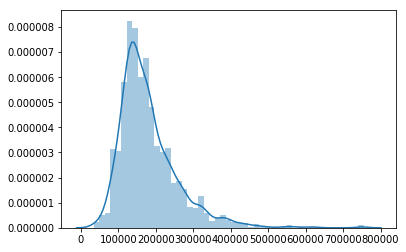

In [182]:
sns.distplot(y_train)

In [183]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [184]:
all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#all_data['YrSold'] = all_data['YrSold'].astype(str)
#all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

In [185]:
#all_data['OverallQual+Cond'] =(all_data['OverallQual']).astype(str) + (all_data['OverallCond']).astype(str)
#all_data['OverallQual*Cond'] =(all_data['OverallQual'] * all_data['OverallCond']).astype(str)
#all_data['Neigh_Zone']  = all_data['Neighborhood'].astype(str) +'_'+ all_data['MSZoning'].astype(str)

In [186]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [187]:
all_data_skew = all_data[all_data.columns[all_data.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>0.75]

In [188]:
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

all_data['TotalBsmt_0'] = (all_data['TotalBsmtSF']==0).astype(int)
all_data['1st-TotalBsmtSF'] = all_data['1stFlrSF'] - all_data['TotalBsmtSF']
all_data['2ndFlr_Flag'] = (all_data['2ndFlrSF']!=0).astype(int)
all_data['BsmtUnfRate'] = all_data['BsmtUnfSF']/all_data['1stFlrSF']
all_data['LowQualRate'] = all_data['LowQualFinSF']/all_data['GrLivArea']
all_data['1st/Lot']     = all_data['1stFlrSF']/all_data['LotArea']
all_data['1st+2ndSF']   = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['2nd/1st']     = all_data['2ndFlrSF'] / all_data['1stFlrSF']
#all_data['YearRemo-Gar'] = all_data['YearRemodAdd'] - all_data['GarageYrBlt']
all_data['1st+2nd+GarSF']= all_data['1st+2ndSF'] + all_data['GarageArea']
all_data['1st+2nd+Gar/Lot'] = all_data['1st+2nd+GarSF'] / all_data['LotArea']

In [189]:
for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [190]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

all_data.fillna(all_data.mean(), inplace=True)

In [191]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [192]:
test_id = test['Id'].values

In [193]:
del train['Id'], test['Id']

In [194]:
y_train_log = np.log(y_train)

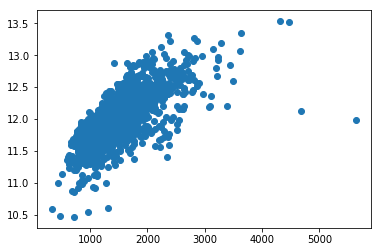

In [195]:
plt.scatter(x=train['GrLivArea'], y=y_train_log)

In [196]:
train[train['GrLivArea']>4000]['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

In [197]:
train = pd.concat([train, pd.DataFrame({'SalePrice':y_train})], axis=1)

In [198]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)
train.drop(train[train['LotArea']>50000].index, inplace=True)
train.drop(train[np.log(train['SalePrice'])<10.7].index, inplace=True)

In [199]:
train.shape

(1443, 80)

In [200]:
def mean_encoding(train, test, cols):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    skf = skf.split(train, train['SalePrice'])
    for col in cols:
        train[col+'_mean_encoding'] = 0
        test[col+'_mean_encoding'] = test[col].map(train.groupby(col)['SalePrice'].mean())
    for tr_idx,val_idx in skf:
        X_tr, X_val = train.iloc[tr_idx, :], train.iloc[val_idx, :]
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col)['SalePrice'].mean())
            train[col+'_mean_encoding'].iloc[val_idx] = means
    prior = train['SalePrice'].mean()
    train.fillna(prior, inplace=True)
    test.fillna(prior, inplace=True)
    return train,test

In [201]:
train, test = mean_encoding(train, test, col_obj)

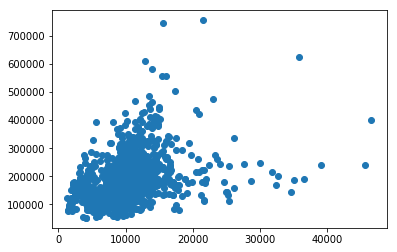

In [202]:
plt.scatter(x=train['LotArea'], y=train['SalePrice'])

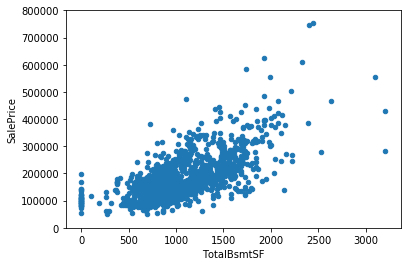

In [203]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

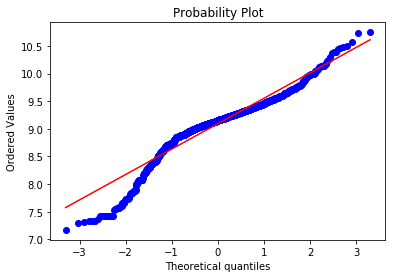

In [204]:
res = stats.probplot(np.log(train['LotArea']), plot=plt)

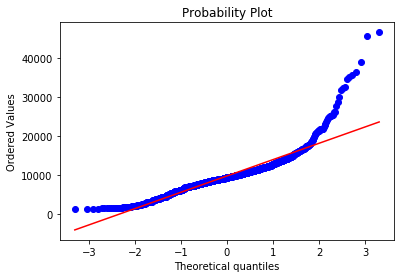

In [205]:
res = stats.probplot(train['LotArea'], plot=plt)

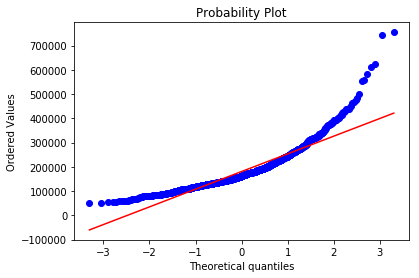

In [206]:
res = stats.probplot(train['SalePrice'], plot=plt)

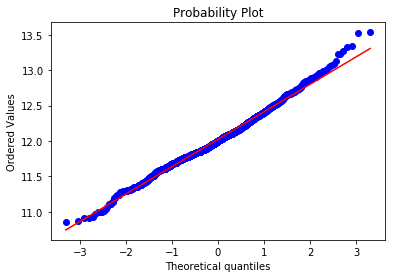

In [207]:
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

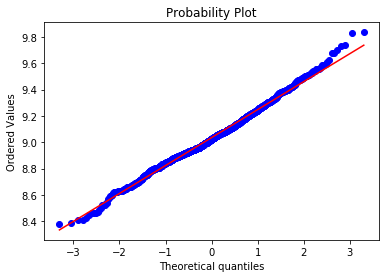

In [208]:
res = stats.probplot(stats.boxcox(train['SalePrice'], lmbda=-0.05), plot=plt)

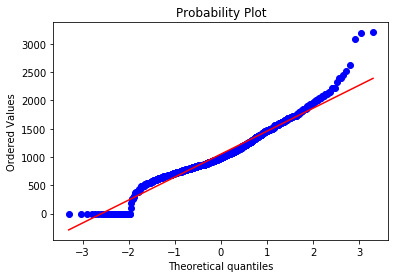

In [209]:
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

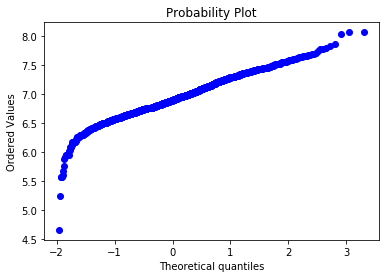

In [210]:
res = stats.probplot(np.log(train['TotalBsmtSF']), plot=plt)

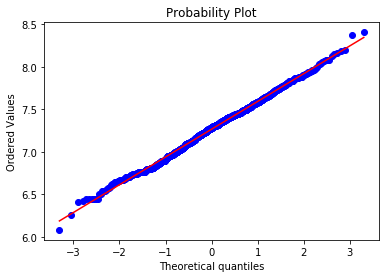

In [211]:
res = stats.probplot(np.log(train['GrLivArea']), plot=plt)

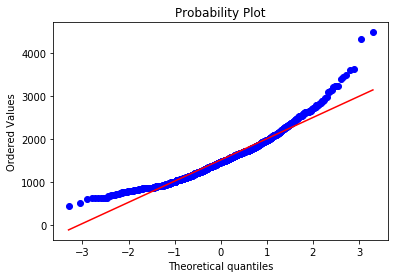

In [212]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [213]:
sf_cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [214]:
cols = ['TotalBsmtSF', 'LotArea']

In [215]:
#for df in [train, test]:
    #df['GrLivArea_log'] = np.log(df['GrLivArea'])        
    #df['YrRem-Bui'] = df['YearRemodAdd'] - df['YearBuilt']
    #for col in sf_cols:
        #df[col+'_sqrt'] = np.sqrt(df[col]) 
        #df[col+'_log'] = np.zeros(df.shape[0])
        #df[col+'_log'].loc[df[df[col]>0].index] = np.log(df[col])

In [216]:
#for df in [train, test]:
#    for col in skewed_columns:
#       df[col] = df[col]+1
#       df[col] =  stats.boxcox(df[col], lmbda=-0.1)

In [217]:
y_train = train['SalePrice'].values
del train['SalePrice']

In [218]:
#all_data = pd.concat([train, test], axis=0)
#ob_col = all_data.columns[all_data.dtypes==object]

In [219]:
#all_data.fillna('NA', inplace=True)

#all_data = pd.get_dummies(all_data)

In [220]:
#train = all_data.iloc[:train.shape[0], :]
#test = all_data.iloc[train.shape[0]:, :]

In [221]:
y_train_log = np.log(y_train)

In [222]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=123)

In [223]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.linear_model import LinearRegression, Lasso

reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

coef = pd.Series(model_lasso.coef_, index = train.columns)

coef

dropf = coef.loc[coef==0].index
print(dropf)

#train = train.drop(dropf, axis=1)

0.12154782017757201
Index(['LotShape', 'LotConfig', 'LandSlope', 'BldgType', 'OverallCond',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'BsmtUnfSF', 'Heating', '2ndFlrSF', 'GarageFinish', 'GarageQual',
       'PoolArea', 'PoolQC', 'MSSubClass_mean_encoding',
       'Street_mean_encoding', 'LotShape_mean_encoding',
       'LandSlope_mean_encoding', 'RoofMatl_mean_encoding',
       'Foundation_mean_encoding', 'Heating_mean_encoding',
       'CentralAir_mean_encoding', 'FireplaceQu_mean_encoding',
       'GarageFinish_mean_encoding', 'PavedDrive_mean_encoding',
       'Fence_mean_encoding', 'MiscFeature_mean_encoding'],
      dtype='object')


In [224]:
coef.sort_values(ascending=False)

GrLivArea                      0.125059
OverallQual_mean_encoding      0.071128
YearRemodAdd                   0.046389
TotalBsmtSF                    0.032585
BsmtFinSF1                     0.031879
Neighborhood_mean_encoding     0.025061
MSZoning_mean_encoding         0.020492
LotArea                        0.019810
FullBath                       0.018318
GarageQual_mean_encoding       0.017581
ScreenPorch                    0.017127
YearBuilt                      0.016402
Exterior1st_mean_encoding      0.015421
BsmtExposure_mean_encoding     0.014895
GarageArea                     0.014793
SaleCondition_mean_encoding    0.012882
BsmtFullBath                   0.012285
Fireplaces                     0.012139
LotFrontage                    0.012088
TotRmsAbvGrd                   0.011270
GarageCars                     0.010267
SaleType_mean_encoding         0.009867
GarageYrBlt                    0.009076
HalfBath                       0.008768
WoodDeckSF                     0.007942


In [225]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 5,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [226]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.346302
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.320068
[3]	valid_0's rmse: 0.296449
[4]	valid_0's rmse: 0.274503
[5]	valid_0's rmse: 0.254313
[6]	valid_0's rmse: 0.236743
[7]	valid_0's rmse: 0.22076
[8]	valid_0's rmse: 0.20631
[9]	valid_0's rmse: 0.193686
[10]	valid_0's rmse: 0.183167
[11]	valid_0's rmse: 0.173977
[12]	valid_0's rmse: 0.165945
[13]	valid_0's rmse: 0.158904
[14]	valid_0's rmse: 0.152488
[15]	valid_0's rmse: 0.146072
[16]	valid_0's rmse: 0.140767
[17]	valid_0's rmse: 0.136368
[18]	valid_0's rmse: 0.132679
[19]	valid_0's rmse: 0.129747
[20]	valid_0's rmse: 0.126596
[21]	valid_0's rmse: 0.12364
[22]	valid_0's rmse: 0.121707
[23]	valid_0's rmse: 0.120558
[24]	valid_0's rmse: 0.119041
[25]	valid_0's rmse: 0.117377
[26]	valid_0's rmse: 0.116172
[27]	valid_0's rmse: 0.115006
[28]	valid_0's rmse: 0.114143
[29]	valid_0's rmse: 0.113425
[30]	valid_0's rmse: 0.112459
[31]	valid_0's rmse: 0.111424
[32]	valid_0's rmse

[178]	valid_0's rmse: 0.125341
Early stopping, best iteration is:
[78]	valid_0's rmse: 0.123916
[1]	valid_0's rmse: 0.376235
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.351721
[3]	valid_0's rmse: 0.329178
[4]	valid_0's rmse: 0.309325
[5]	valid_0's rmse: 0.290959
[6]	valid_0's rmse: 0.275585
[7]	valid_0's rmse: 0.261385
[8]	valid_0's rmse: 0.249835
[9]	valid_0's rmse: 0.237421
[10]	valid_0's rmse: 0.226774
[11]	valid_0's rmse: 0.218276
[12]	valid_0's rmse: 0.209989
[13]	valid_0's rmse: 0.201796
[14]	valid_0's rmse: 0.195746
[15]	valid_0's rmse: 0.189338
[16]	valid_0's rmse: 0.183648
[17]	valid_0's rmse: 0.180002
[18]	valid_0's rmse: 0.176507
[19]	valid_0's rmse: 0.172411
[20]	valid_0's rmse: 0.168965
[21]	valid_0's rmse: 0.165918
[22]	valid_0's rmse: 0.163231
[23]	valid_0's rmse: 0.160593
[24]	valid_0's rmse: 0.158203
[25]	valid_0's rmse: 0.156115
[26]	valid_0's rmse: 0.153881
[27]	valid_0's rmse: 0.151514
[28]	valid_0's rmse: 0.149503
[29]	valid

[78]	valid_0's rmse: 0.106381
[79]	valid_0's rmse: 0.106392
[80]	valid_0's rmse: 0.106524
[81]	valid_0's rmse: 0.106608
[82]	valid_0's rmse: 0.106485
[83]	valid_0's rmse: 0.106463
[84]	valid_0's rmse: 0.106615
[85]	valid_0's rmse: 0.106377
[86]	valid_0's rmse: 0.106382
[87]	valid_0's rmse: 0.106168
[88]	valid_0's rmse: 0.106365
[89]	valid_0's rmse: 0.106102
[90]	valid_0's rmse: 0.106087
[91]	valid_0's rmse: 0.106186
[92]	valid_0's rmse: 0.106143
[93]	valid_0's rmse: 0.106205
[94]	valid_0's rmse: 0.106139
[95]	valid_0's rmse: 0.10615
[96]	valid_0's rmse: 0.106123
[97]	valid_0's rmse: 0.106189
[98]	valid_0's rmse: 0.106231
[99]	valid_0's rmse: 0.106294
[100]	valid_0's rmse: 0.10624
[101]	valid_0's rmse: 0.106243
[102]	valid_0's rmse: 0.106293
[103]	valid_0's rmse: 0.10624
[104]	valid_0's rmse: 0.106147
[105]	valid_0's rmse: 0.106267
[106]	valid_0's rmse: 0.106199
[107]	valid_0's rmse: 0.106442
[108]	valid_0's rmse: 0.106541
[109]	valid_0's rmse: 0.106602
[110]	valid_0's rmse: 0.106615
[1

[202]	valid_0's rmse: 0.125639
[203]	valid_0's rmse: 0.125668
[204]	valid_0's rmse: 0.125672
[205]	valid_0's rmse: 0.125655
[206]	valid_0's rmse: 0.125693
[207]	valid_0's rmse: 0.125817
[208]	valid_0's rmse: 0.125811
[209]	valid_0's rmse: 0.125808
[210]	valid_0's rmse: 0.125678
[211]	valid_0's rmse: 0.125722
[212]	valid_0's rmse: 0.125791
[213]	valid_0's rmse: 0.125915
[214]	valid_0's rmse: 0.125934
[215]	valid_0's rmse: 0.125964
[216]	valid_0's rmse: 0.125966
[217]	valid_0's rmse: 0.125942
[218]	valid_0's rmse: 0.126013
[219]	valid_0's rmse: 0.125971
[220]	valid_0's rmse: 0.126035
Early stopping, best iteration is:
[120]	valid_0's rmse: 0.125079


In [227]:
np.sum(val_rmse)/n_folds

0.11855565931977807

In [228]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [229]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
GrLivArea,96.0
LotArea,58.8
TotalBsmtSF,51.2
BsmtFinSF1,51.2
Neighborhood_mean_encoding,42.2
GarageArea,39.4
1stFlrSF,36.2
OverallCond_mean_encoding,35.6
YearRemodAdd,33.6
OverallQual_mean_encoding,30.0


In [230]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.1138479005874236
{'gamma': 0.0001, 'epsilon': 0.01, 'C': 100}


In [235]:
preds_svr = svr.predict(test_ss)

In [233]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

0.12175543398686525


In [240]:
preds_lasso = None

for model in reg_lasso:
    if preds_lasso is None:
        preds_lasso = model.predict(test_ss) / n_folds
    else:
        preds_lasso += model.predict(test_ss) / n_folds

In [237]:
preds_lgb = None

for model in reg:
    if preds_lgb is None:
        preds_lgb = model.predict(test) / n_folds
    else:
        preds_lgb += model.predict(test) / n_folds

In [241]:
preds = 0.2 * np.exp(preds_lasso) + 0.3 * np.exp(preds_lgb) + 0.5 * np.exp(preds_svr)

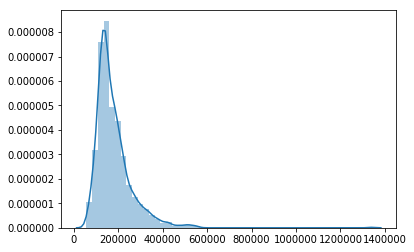

In [242]:
sns.distplot(preds)

In [251]:
solution = pd.DataFrame({"id":test_id, "SalePrice":preds})
solution.to_csv("submission_38.csv", index = False)